In [120]:
%matplotlib inline
import cloudpickle
import redis
import lz4.frame
import subprocess

import numpy as np
import time

import uproot
import uproot_methods
import numpy as np
import awkward

import os
import sys

import pandas as pd

import concurrent.futures
from tqdm.auto import tqdm

import glob
import functools

import matplotlib.pyplot as plt

In [121]:
# functions to pickle and unpickle (to/from string) with lz4 compression
# note, cloudpickle requires same python version used locally and on worker!!
# this could be relaxed with a different pickle protocol in dumps(), but then life gets messier
def compress_and_dumps(obj):
    return lz4.frame.compress(cloudpickle.dumps(obj),compression_level=lz4.frame.COMPRESSIONLEVEL_MINHC)

def decompress_and_loads(obj):
    return cloudpickle.loads(lz4.frame.decompress(obj))

In [122]:
def get_met_hist(fname,entrystart=0,entrystop=None,bins=np.linspace(0,500,500)):
    """
    return 
    - event count considered
    - array of histogram bin counts for 1D MET distribution
    """
    f = uproot.open(fname)
    t = f["Events"]
    arr = t.array("MET_pt",entrystart=entrystart,entrystop=entrystop)#,cache=cache)
    nevents = len(arr)
    counts,_ = np.histogram(np.clip(arr,bins[0],bins[-1]),bins=bins)
    return (nevents,counts)

def get_mll_hist(fname,entrystart=0,entrystop=None,bins=np.linspace(0,500,1000)):
    """
    return 
    - event count considered
    - array of histogram bin counts for m(mumu) for nmu==2 events
    """
    f = uproot.open(fname)
    t = f["Events"]
    p4 = uproot_methods.TLorentzVectorArray.from_ptetaphim(
        *t.arrays(
            ["Muon_pt","Muon_eta","Muon_phi","Muon_mass"],
            outputtype=tuple,
            namedecode="ascii",
            entrystart=entrystart,
            entrystop=entrystop,
        ),
    )
    nevents = len(p4)
    pairs = p4[p4.counts==2]
    mll = (pairs[:,0]+pairs[:,1]).mass
    counts,_ = np.histogram(np.clip(mll,bins[0],bins[-1]),bins=bins)
    return (nevents,counts)

In [123]:
# Either hardcode `fullurl` here to the proper redis url, or put it `secret.txt`

# fullurl = "redis://:blah@ec2-1-2-3-4.us-west-1.compute.amazonaws.com:6379"
fullurl = open("secret.txt").read().strip()
r = redis.Redis.from_url(fullurl)

In [124]:
# queue name relies on username to avoid clashes
user = os.getenv("USER")
qname_results = user+":results"
qname_tasks = user+":tasks"

In [125]:
df = pd.DataFrame(r.client_list()).query("flags!='N'")[["addr","name","age","id","idle"]]
print(" {} total workers ".format(df.shape[0]).center(50,"="))
df.head()

================ 10 total workers ================


,addr,name,age,id,idle
1,169.228.132.181:6980,namin__sdsc-82.t2.ucsd.edu__mytask1__10183501.2,329,1520,43
2,169.228.131.64:41573,namin__cabinet-5-5-5.t2.ucsd.edu__mytask1__101...,329,1521,32
4,169.228.131.46:42292,namin__cabinet-5-5-23.t2.ucsd.edu__mytask1__10...,324,1523,44
5,169.228.131.80:44586,namin__cabinet-4-4-26.t2.ucsd.edu__mytask1__10...,329,1517,21
6,169.228.132.102:33790,namin__sdsc-3.t2.ucsd.edu__mytask1__10183501.8,318,1525,43


In [126]:
@functools.lru_cache(maxsize=128)
def get_chunking(filelist, chunksize, treename="Events", workers=1):
    """
    Return 2-tuple of
    - chunks: triplets of (filename,entrystart,entrystop) calculated with input `chunksize` and `filelist`
    - total_nevents: total event count over `filelist`
    """
    print("Recomputing")
    chunks = []
    executor = None if len(filelist) < 5 else concurrent.futures.ThreadPoolExecutor(workers)
    nevents = 0
    for fn, nentries in uproot.numentries(filelist, treename, total=False, executor=executor,).items():
        nevents += nentries
        for index in range(nentries // chunksize + 1):
            chunks.append((fn, chunksize*index, chunksize*(index+1)))
    return chunks,nevents

In [127]:
%%time
fnames = sorted(glob.glob("/hadoop/cms/store/user/namin/nanoaod/DoubleMuon__Run*/*.root"))

# For testing, just 20 files (doublemu has ~130 total)
fnames = fnames[:20]

chunks, total_nevents = get_chunking(tuple(fnames),int(1.0e6))
print("{} chunks of {} files, with a total of {:.5g} events".format(len(chunks),len(fnames),total_nevents))

Recomputing
39 chunks of 20 files, with a total of 2.9259e+07 events
CPU times: user 1.73 s, sys: 24 ms, total: 1.75 s
Wall time: 2.48 s


In [128]:
# Flush old results/tasks in case we quit before consuming all of them
r.delete(qname_results,qname_tasks)

t0 = time.time()

# Plot MET branch (fast) or dimuon mass (slower)?
do_met = True
# do_met = False

if do_met:
    # 1D histogram of MET
    bins = np.linspace(0,500,500)
    f = get_met_hist
else:
    # 1D histogram of dimuon invariant mass
    # log spaced binning for cleaner low mass resonances
    bins = np.logspace(np.log10(0.5),np.log10(1000),num=300)
    f = get_mll_hist
    
# Push all task function/args to the broker
# Use a pipeline to put all lpushes into a single transfer
# (~500 lpushes takes a few seconds otherwise)
print("Start pushing tasks to broker")
pipe = r.pipeline()
for fname,entrystart,entrystop in chunks:
    pipe.lpush(qname_tasks,compress_and_dumps([
        functools.partial(f,bins=bins,entrystart=entrystart,entrystop=entrystop),
        fname
    ]))
pipe.execute()
print("Done pushing tasks to broker")

# Read results from broker
results = []
bar = tqdm(total=total_nevents,unit_scale=True,unit="event")
while len(results) < len(chunks):
    tofetch = r.llen(qname_results)
    # avoid spamming pops requests too fast
    if tofetch == 0: 
        time.sleep(0.5)
        continue
    pipe = r.pipeline()
    for _ in range(tofetch):
        pipe.brpop(qname_results)
    popchunk = pipe.execute()
    for pc in popchunk:
        if pc is None: continue
        key,res_raw = pc
        meta,(nevents,counts) = decompress_and_loads(res_raw)
        results.append(dict(
            fname=meta["args"],
            nevents=nevents,
            counts=counts,
            client=meta["client_name"],
            elapsed=meta["elapsed"],
        ))
        bar.update(nevents)
t1 = time.time()
print("{:.5g} events in {:.2f}s @ {:.2f}MHz".format(total_nevents,t1-t0,1.0e-6*total_nevents/(t1-t0)))

Start pushing tasks to broker
Done pushing tasks to broker


2.9259e+07 events in 10.00s @ 2.93MHz


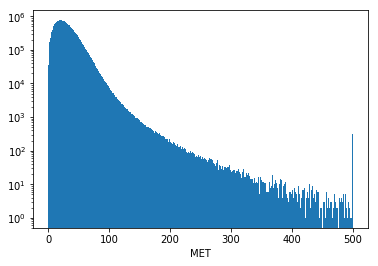

In [129]:
# sum up the histograms
counts = sum([x["counts"] for x in results])
if do_met:
    centers = 0.5*(bins[1:]+bins[:-1])
    fig,ax = plt.subplots()
    ax.hist(centers,weights=counts,bins=bins);
    ax.set_yscale("log")
    ax.set_xlabel("MET")
else:
    print("{:.5g} total muons".format(counts.sum()))
    # log spaced bin centers (matching the inputs)
    centers = np.power(10.,0.5*(np.log10(bins[:-1])+np.log10(bins[1:])))
    fig,ax = plt.subplots()
    ax.hist(centers,weights=counts,bins=bins);
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Invariant mass")

In [130]:
r.info("all")["cmdstat_brpop"]

{'calls': 961172, 'usec': 1208532, 'usec_per_call': 1.26}

In [131]:
df = pd.DataFrame(results).drop(["counts"],axis=1)
df["rate"] = df["nevents"]/df["elapsed"]
# Stats for nodes we ran on. Show slowest nodes (Hz) at the top.
df.groupby(df.client.str.split(".",1).str[0])["rate"].mean().sort_values()

client
namin__cabinet-8-8-7     236688.320416
namin__sdsc-2            281462.328544
namin__sdsc-3            308413.058207
namin__cabinet-5-5-23    331646.092043
namin__sdsc-83           339519.218708
namin__cabinet-4-4-26    358459.402116
namin__cabinet-5-5-5     406493.193771
namin__sdsc-82           531932.554958
Name: rate, dtype: float64